In [1]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)


In [2]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]





In [3]:
from sklearn.base import BaseEstimator, ClusterMixin
import math
import random

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """

    def __init__(self, **kwargs):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.epsilon = kwargs.get('epsilon', 0.1)
        self.min_pts = kwargs.get('min_pts', 5)
        self.x_len = 0
        self.y_len = 0
        self.last_point_class = 0
        self.df = pd.DataFrame()
        self.distinct_clusters = []
        return

    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        if y is None or self.__nd_array_length(x) == self.__nd_array_length(y):
            (length, data_columns_length) = x.shape
            self.x_len = length
            self.x_data_columns_length = data_columns_length
            self.param_columns = [self.__param_column(column) for column in range(self.x_data_columns_length)]
            self.y_len = None if y is None else self.__nd_array_length(y)
            self.df = self.__prepare_data_frame_for_algorithm(x)
            self.__perform()
            self.__normalize_classes()
        else:
            raise AttributeError("'Can't fit when Y and X different lenghs X is {0}, Y is {1}'".format(self.__nd_array_length(x), self.__nd_array_length(y)))

        return self

    def __prepare_data_frame_for_algorithm(self, x):
        processed_column = np.full((self.x_len,1), False, dtype=bool)
        class_column = np.full((self.x_len, 1), -2, dtype=object)
        columns = self.param_columns + ['processed', 'class']
        data_array = x.astype(object)
        final_numpy_array = np.hstack((data_array, processed_column, class_column))
        return pd.DataFrame(final_numpy_array, columns=columns)

    def __param_column(self, index):
        return '{0} param'.format(index)

    def __nd_array_length(self, array):
        return array.shape[0]

    def __perform(self):
        for (row_index, row) in self.df.iterrows():
            if self.__is_processed(row):
                continue
            else:
                self.df.loc[row_index, ['processed']] = True
                near_points = self.__find_near_points(row)
                other_classes_points = near_points[(near_points['class'] != -1) & (near_points['class'] != -2)]
                if len(other_classes_points) > 0:
                    distinct_points_classes = list(set(other_classes_points.get('class').tolist()))
                    random_class = random.choice(distinct_points_classes)
                    self.df.loc[self.df['class'].isin(distinct_points_classes), ['class']] = random_class
                    self.df.loc[near_points.index.tolist() + [row_index], ['class']] = random_class
                    self.df.loc[near_points.index.tolist(), ['processed']] = True
                else:
                    if len(near_points) < self.min_pts:
                        self.df.loc[row_index, ['class']] = -1
                    else:
                        point_class = self.__get_point_class()
                        self.df.loc[near_points.index.tolist() + [row_index], ['class']] = point_class
        self.df = self.df.drop(['distance', 'processed'], axis=1)
        self.distinct_clusters = self.__calculate_distinct_classes()
        self.distinct_clusters.sort()
        
        return True

    def __calculate_distinct_classes(self):
        not_noisy_elements_ids = self.df.loc[self.df['class'] != -1].index.tolist()
        return list(set(self.df.loc[not_noisy_elements_ids].get('class').tolist()))

    def __normalize_classes(self):
        for new_class in range(self.clusters_amount()):
            self.df.loc[self.df['class'] == self.distinct_clusters[new_class]] = new_class
        return True

    def __find_near_points(self, point):
        def distance_to_point(data_frame_point, point_params):
            sqr_sum = 0
            for param_column in self.param_columns:
                sqr_sum += math.pow(data_frame_point[param_column] - point_params[param_column], 2)
            return math.sqrt(sqr_sum)

        params = self.__get_params(point)
        self.df['distance'] = self.df.apply(lambda row: distance_to_point(row, params), axis=1)

        epsilon_neighborgood = ["(self.df['distance'] <= self.epsilon)"]
        not_current_point = ["(self.df['{0}'] != params['{0}'])".format(param_column) for param_column in self.param_columns]
        near_points_query = ' & '.join(epsilon_neighborgood + not_current_point)

        return self.df.loc[eval(near_points_query)]

    def __get_point_class(self):
        self.last_point_class += 1
        return self.last_point_class

    def __get_params(self, row):
        params = row[0:self.x_data_columns_length]
        return params 

    def __is_processed(self, row):
        return row['processed']

    def __get_class(self, row):
        return row['class']

    def predict(self, y=None):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        return np.array(self.df.get('class').tolist())

    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(y)

    def noise_percent(self):
        if self.x_len > 0:
            noise_elements = len(self.df.loc[(self.df['class'] == -1)].index.tolist())
            return round(noise_elements / self.x_len, 4)
        else:
            return 0.0

    def clusters_amount(self):
        return len(self.distinct_clusters)

    def print_report(self):
        print("Clusters amount {0}, noise percent {1}".format(self.clusters_amount(), c.noise_percent()))
        return True

    def quality(self, y):
        return smt.adjusted_rand_score(y, self.predict())

Adjusted Rand index for iris is: 1.00
Clusters amount 2, noise percent 0.0


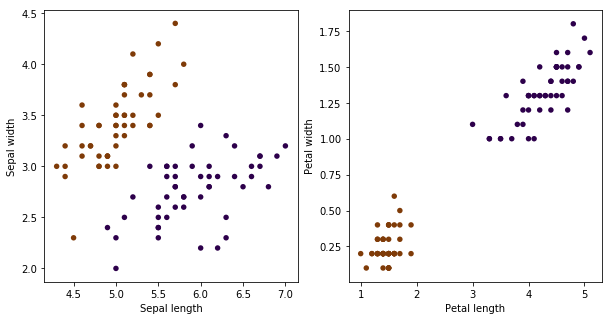

In [4]:

iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]


c = Clustering(epsilon=1, min_pts=2)
c.fit(x_iris)
pred_iris = c.predict()
print("Adjusted Rand index for iris is: %.2f" % c.quality(y_iris))
c.print_report()
pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=pred_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=pred_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

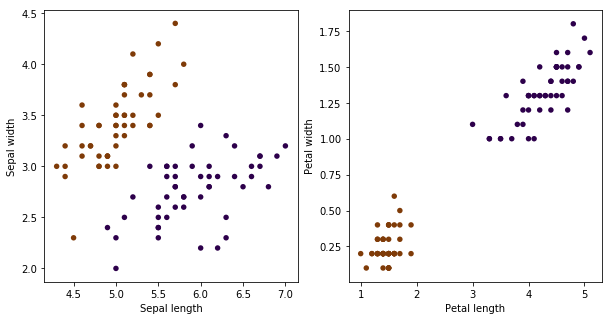

In [5]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Удалось подобрать параметры алгоритма, которые позволилил идеально кластеризовать множество точек. Предположим что мне просто повезло.

Посмотрим как себя показывает алгоритм при разных значениях параметров `min_pts` и `epsilon`

In [74]:

iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]
epsilon_set = [0.2, 0.4, 0.6, 0.8, 1, 1.5, 2]
min_pts_set = [2, 4, 6, 8, 10]

def grid_search(epsilon_set, min_pts_set):
    accuracy = np.zeros((len(min_pts_set), len(epsilon_set)))
    clusters_amount = np.zeros((len(min_pts_set), len(epsilon_set)))
    noise_percent = np.zeros((len(min_pts_set), len(epsilon_set)))

    for min_pts_index in range(len(min_pts_set)):
        for epsilon_index in range(len(epsilon_set)):
            c = Clustering(epsilon=epsilon_set[epsilon_index], min_pts=min_pts_set[min_pts_index])
            c.fit(x_iris)
            accuracy[min_pts_index][epsilon_index] = c.quality(y_iris)
            clusters_amount[min_pts_index][epsilon_index] = c.clusters_amount()
            noise_percent[min_pts_index][epsilon_index] = c.noise_percent()

    return (accuracy, clusters_amount, noise_percent)

(ac, clis_am, noise_per) = grid_search(epsilon_set, min_pts_set)



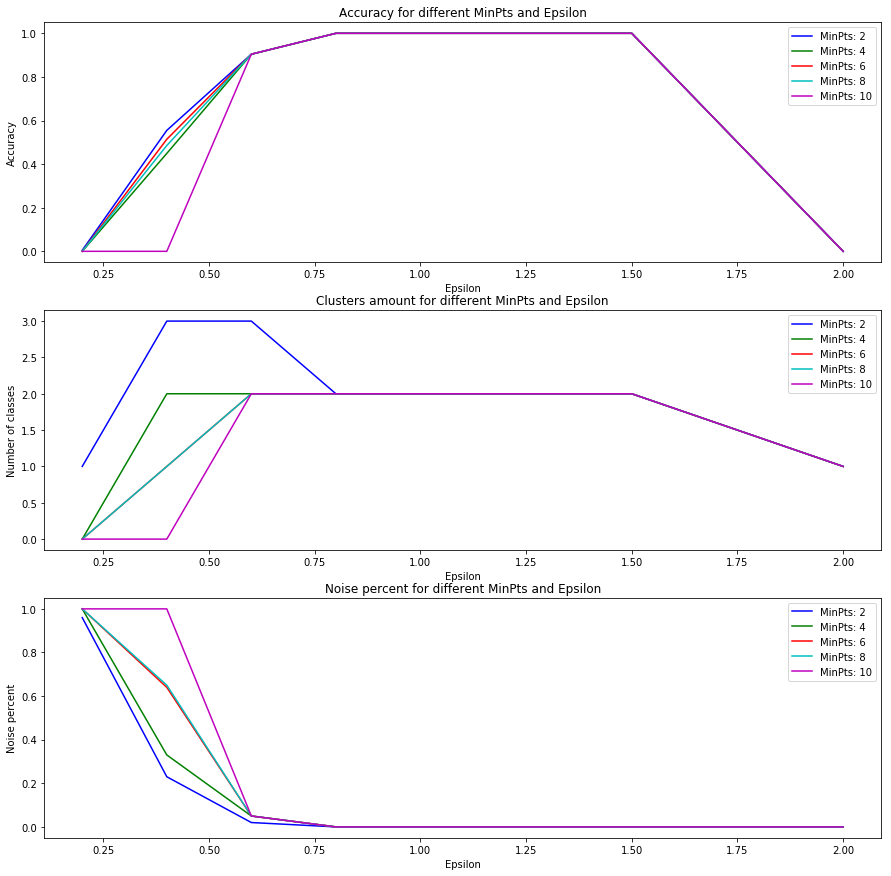

In [75]:
def print_plots(accuracy, clusters_amount, noise_percent, epsilon_set, min_pts_set):
    (min_pts_count, _epsilon_amount) = accuracy.shape
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    alg_fig, alg_ax = pl.subplots(3)

    for min_pts_index in range(min_pts_count):
        alg_ax[0].plot(epsilon_set, accuracy[min_pts_index], color=colors[min_pts_index], label='MinPts: {0}'.format(min_pts_set[min_pts_index]))

        alg_ax[0].set_title('Accuracy for different MinPts and Epsilon')
        alg_ax[0].legend()
        alg_ax[0].set_xlabel('Epsilon')
        alg_ax[0].set_ylabel('Accuracy')

        alg_ax[1].plot(epsilon_set, clusters_amount[min_pts_index], color=colors[min_pts_index], label='MinPts: {0}'.format(min_pts_set[min_pts_index]))

        alg_ax[1].set_title('Clusters amount for different MinPts and Epsilon')
        alg_ax[1].legend()
        alg_ax[1].set_xlabel('Epsilon')
        alg_ax[1].set_ylabel('Number of classes')

        alg_ax[2].plot(epsilon_set, noise_percent[min_pts_index], color=colors[min_pts_index], label='MinPts: {0}'.format(min_pts_set[min_pts_index]))

        alg_ax[2].set_title('Noise percent for different MinPts and Epsilon')
        alg_ax[2].legend()
        alg_ax[2].set_xlabel('Epsilon')
        alg_ax[2].set_ylabel('Noise percent')

    plt.rcParams["figure.figsize"] = [15, 15]
    plt.show()

print_plots(ac, clis_am, noise_per, epsilon_set, min_pts_set)

Как видно из графиков - оптимальное значение Epsilon = [0.8, 1.5] MinPts = [4,6,8,10].

Проверим как алгоритм работает на других дата сетах

In [20]:
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

n_samples = 1500

noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)

def predict_and_compare(points_set, epsilon, min_pts, title):
    # Calculations
    (x, y) = points_set
    c = Clustering(epsilon=epsilon, min_pts=min_pts)
    c.fit(x)
    y_pred = c.predict()
    # Print report
    print(title)
    c.print_report()
    draw_plots(title, x, y, y_pred)
    return True

def draw_plots(title, x, y, y_pred):
    print("Adjusted Rand index for {0} is: {1}".format(title, '%.2f' % quality(y, y_pred)))
    print('Comparing {0}'.format(title))

    # Add one to all values with they display. Classes starts from 0 value, this color does not display.
    y = y + 1

    plt.scatter(x[:, 0], x[:, 1], s=y)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Original {0}'.format(title))
    plt.show()
    
    print('--------------------')
    
    plt.scatter(x[:, 0], x[:, 1], s=y_pred + 1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Predicted {0}'.format(title))
    plt.show()
    return True

Noisy moons
Clusters amount 2, noise percent 0.0
Comparing Noisy moons
Adjusted Rand index for Noisy moons is: 1.00


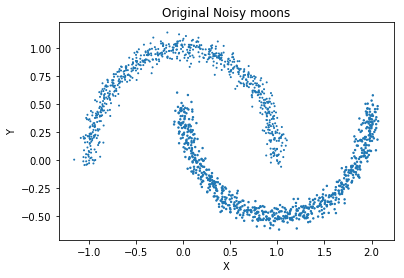

--------------------


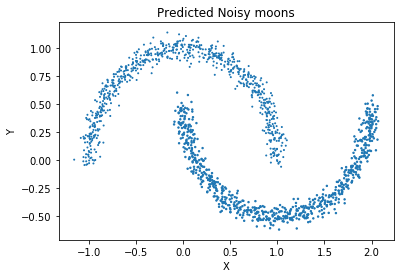

True

In [46]:
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

predict_and_compare(noisy_moons, 0.2, 3, 'Noisy moons')

Blobs
Adjusted Rand index for Blobs is: 1.00
Clusters amount 3, noise percent 0.0
Comparing Blobs


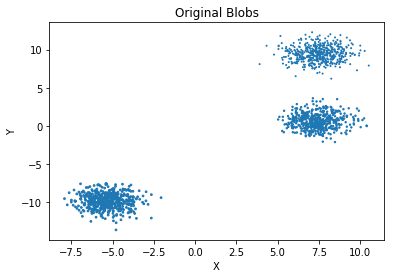

--------------------


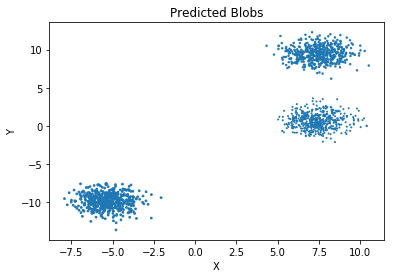

True

In [190]:
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

predict_and_compare(blobs, 1, 3, 'Blobs')

Noisy circles
Adjusted Rand index for Noisy circles is: 1.00
Clusters amount 2, noise percent 0.0
Comparing Noisy circles


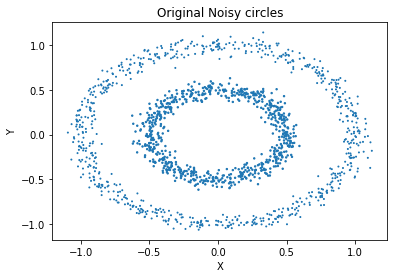

--------------------


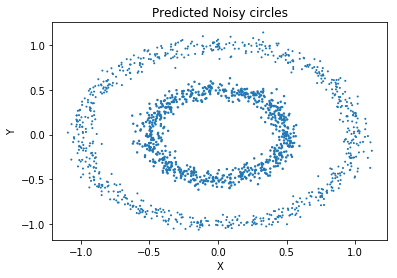

True

In [192]:
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)

predict_and_compare(noisy_circles, 0.2, 3, 'Noisy circles')

Как видно - алгоритм работает и при 2х мерной размерности и со 100% точностью. Тоесть при наличии чёткого разделения - работает корректно.

Сравним с алгоритмомм включённым в библиотеку SKLEARN

Comparing Sklearn Noisy moons
Adjusted Rand index for Sklearn Noisy moons is: 1.00


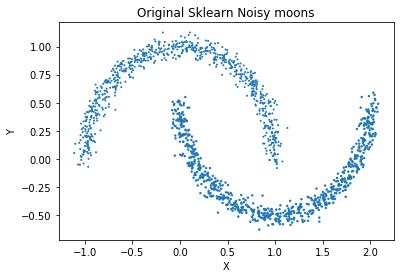

--------------------


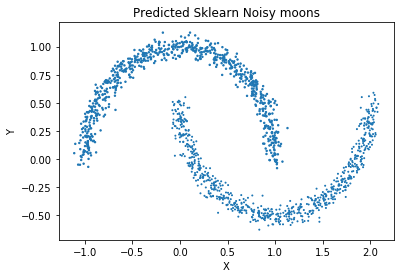

True

In [50]:
from sklearn.cluster import DBSCAN

n_samples = 1500

def quality(y_stand, y_pred):
    return smt.adjusted_rand_score(y_stand, y_pred)

def predict_and_compare(points_set, epsilon, min_pts, title):
    # Calculations
    (x, y) = points_set
    cluster = DBSCAN(eps=epsilon, min_samples=min_pts)
    cluster.fit(x)
    y_pred = cluster.labels_

    # Print report
    draw_plots(title, x, y, y_pred)
    return True

def draw_plots(title, x, y, y_pred):
    print('Comparing {0}'.format(title))
    print("Adjusted Rand index for {0} is: {1}".format(title, '%.2f' % quality(y, y_pred)))

    # Add one to all values with they display. Classes starts from 0 value, this color does not display.
    y = y + 1

    plt.scatter(x[:, 0], x[:, 1], s=y)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Original {0}'.format(title))
    plt.show()

    print('--------------------')

    plt.scatter(x[:, 0], x[:, 1], s=y_pred + 1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Predicted {0}'.format(title))
    plt.show()
    return True

Comparing Sklearn Noisy moons
Adjusted Rand index for Sklearn Noisy moons is: 1.00


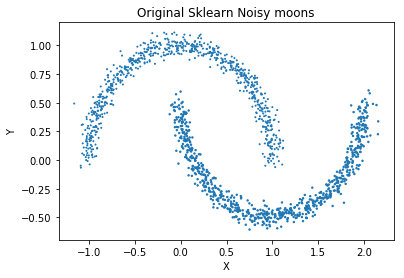

--------------------


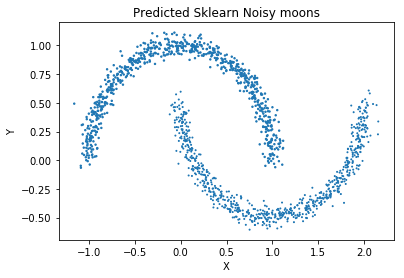

True

In [56]:

noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
predict_and_compare(noisy_moons, 0.2, 3, 'Sklearn Noisy moons')

Comparing Sklearn Blobs
Adjusted Rand index for Sklearn Blobs is: 1.00


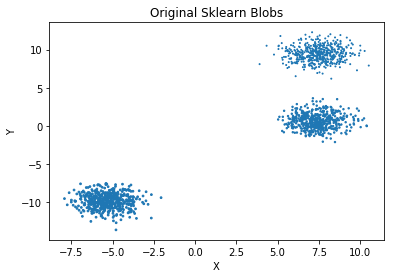

--------------------


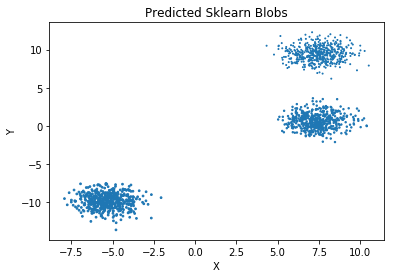

True

In [57]:
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

predict_and_compare(blobs, 1, 3, 'Sklearn Blobs')

Comparing Sklearn Noisy circles
Adjusted Rand index for Sklearn Noisy circles is: 1.00


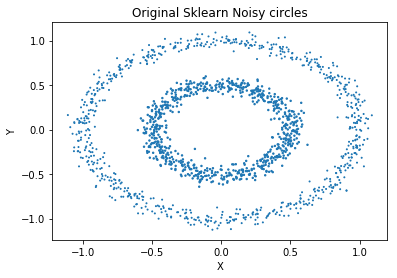

--------------------


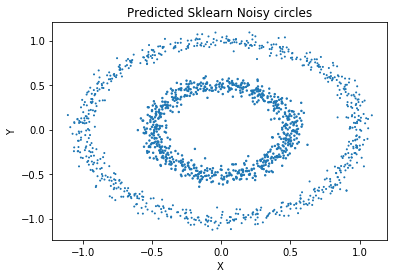

True

In [58]:
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)

predict_and_compare(noisy_circles, 0.2, 3, 'Sklearn Noisy circles')

In [ ]:
Как видно - точность абсолютно идентична. Однако по производительности версия Sklearn сущестенно быстрее.

Сравним показатели в GridSearch на Iris дата сете.

In [70]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]
epsilon_set = [0.2, 0.4, 0.6, 0.8, 1, 1.5, 2]
min_pts_set = [2, 4, 6, 8, 10]

def quality(y_stand, y_pred):
    return smt.adjusted_rand_score(y_stand, y_pred)

def calculate_clusters_amount(y):
    return len(set(y))

def grid_search(epsilon_set, min_pts_set):
    accuracy = np.zeros((len(min_pts_set), len(epsilon_set)))
    clusters_amount = np.zeros((len(min_pts_set), len(epsilon_set)))

    for min_pts_index in range(len(min_pts_set)):
        for epsilon_index in range(len(epsilon_set)):
            cluster = DBSCAN(eps=epsilon_set[epsilon_index], min_samples=min_pts_set[min_pts_index])
            cluster.fit(x_iris)
            y_pred = cluster.labels_
            accuracy[min_pts_index][epsilon_index] = quality(y_iris, y_pred)
            clusters_amount[min_pts_index][epsilon_index] = calculate_clusters_amount(y_pred)

    return (accuracy, clusters_amount)

(ac, clus_am) = grid_search(epsilon_set, min_pts_set)

Sklearn DB scan grid search graphics


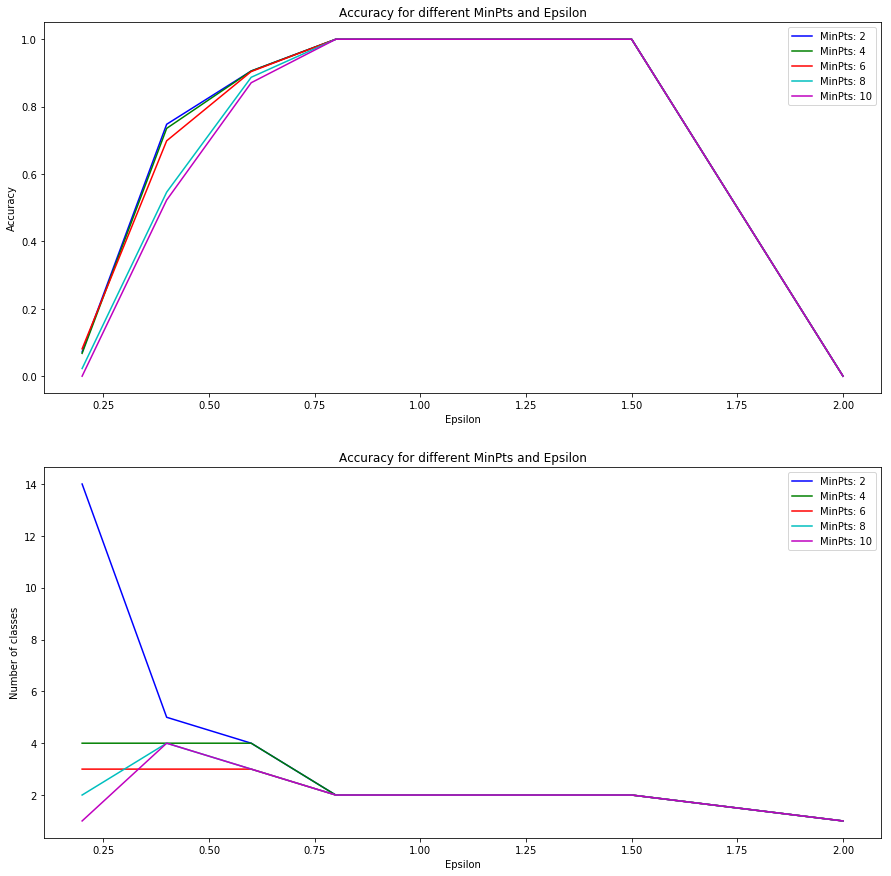

In [73]:
def print_plots(accuracy, clusters_amount, epsilon_set, min_pts_set):
    print('Sklearn DB scan grid search graphics')
    (min_pts_count, _epsilon_amount) = accuracy.shape
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    alg_fig, alg_ax = pl.subplots(2)

    for min_pts_index in range(min_pts_count):
        alg_ax[0].plot(epsilon_set, accuracy[min_pts_index], color=colors[min_pts_index], label='MinPts: {0}'.format(min_pts_set[min_pts_index]))

        alg_ax[0].set_title('Accuracy for different MinPts and Epsilon')
        alg_ax[0].legend()
        alg_ax[0].set_xlabel('Epsilon')
        alg_ax[0].set_ylabel('Accuracy')

        alg_ax[1].plot(epsilon_set, clusters_amount[min_pts_index], color=colors[min_pts_index], label='MinPts: {0}'.format(min_pts_set[min_pts_index]))

        alg_ax[1].set_title('Accuracy for different MinPts and Epsilon')
        alg_ax[1].legend()
        alg_ax[1].set_xlabel('Epsilon')
        alg_ax[1].set_ylabel('Number of classes')

    plt.rcParams["figure.figsize"] = [15, 15]
    plt.show()

print_plots(ac, clus_am, epsilon_set, min_pts_set)

## Заключкение

Был реализован алгоритм DBSCAN. При правильно заданных параметрах Epsilon и MinPts позволяет кластеризовать любой дата сет, независимо от его размерности.
При сравнении с Sklearn, существенно проигрывает по производителности. Но даёт аналогичные результаты по точности.